Combined method onset: 0.012s


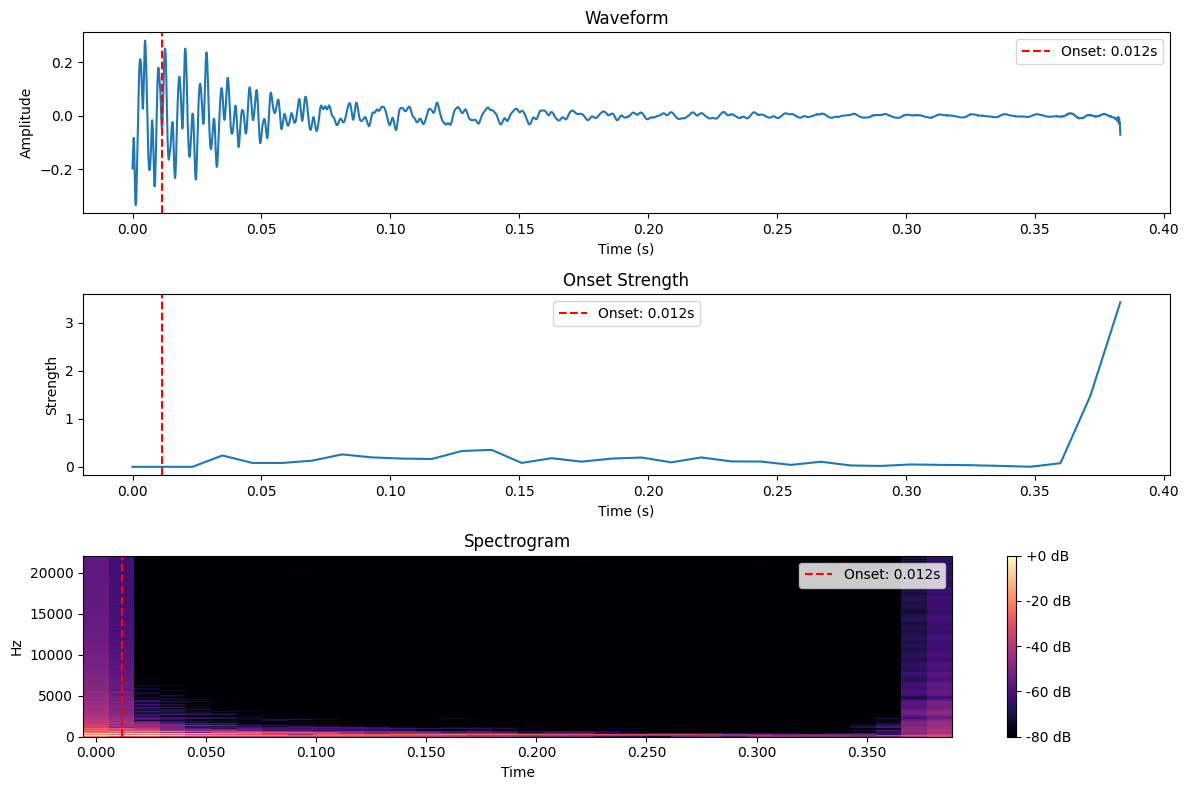

In [ ]:
import librosa
import numpy as np
from typing import List, Tuple, Optional
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.signal

def get_audio(path: Path) -> Tuple[np.array, float]:
    """
    Load audio file.
    Args:
        path: Path to audio file
    Returns:
        Tuple of audio signal and sample rate
    """
    audio, sr = librosa.load(path, sr=22050)
    return audio, sr

def get_onset(audio: np.array, sr: float) -> Optional[float]:
    """
    Improved onset detection specifically for mridangam percussion.
    
    Args:
        audio: Audio signal
        sr: Sample rate
    Returns:
        Onset time in seconds
    """
    # Method 1: Spectral flux
    spectral_onsets = librosa.onset.onset_detect(
        y=audio, sr=sr, units='time',
        onset_envelope=librosa.onset.onset_strength(y=audio, sr=sr),
        pre_max=3, post_max=3, pre_avg=3, post_avg=3,
        delta=0.3, wait=5
    )
    
    # Method 2: Energy-based (fix: compute RMS separately)
    rms_features = librosa.feature.rms(y=audio)[0]
    # Convert RMS to onset strength manually
    rms_diff = np.diff(rms_features, prepend=rms_features[0])
    rms_diff = np.maximum(0, rms_diff)  # Only positive changes
    
    energy_onsets = librosa.onset.onset_detect(
        onset_envelope=rms_diff,
        sr=sr, units='time',
        pre_max=3, post_max=3, pre_avg=3, post_avg=3,
        delta=0.4, wait=5
    )
    
    # Combine all detected onsets
    all_onsets = np.concatenate([spectral_onsets, energy_onsets])
    
    # Remove duplicates within 50ms window
    if len(all_onsets) > 0:
        all_onsets = np.sort(all_onsets)
        unique_onsets = [all_onsets[0]]
        for onset in all_onsets[1:]:
            if onset - unique_onsets[-1] > 0.05:  # 50ms threshold
                unique_onsets.append(onset)
        onset_times = np.array(unique_onsets)
    else:
        onset_times = all_onsets
    
    return onset_times[0] if len(onset_times) > 0 else None

def get_window(onset: float, audio: np.array, sr: float, 
                       pre_onset: float = 0.05, post_onset: float = 0.15) -> np.array:
    """
    Get audio window around onset with adaptive timing based on audio energy.
    """
    duration: float = pre_onset + post_onset
    window_samples: int = int(duration * sr)
    if onset is None:
        if len(audio) >= window_samples:
            return audio[:window_samples]
        else:
            # Pad if audio is shorter than window
            return np.pad(audio, (0, window_samples - len(audio)), mode='constant')
    
    # Calculate window boundaries
    # Put onset at 25% of window (to capture pre-attack)
    pre_onset_duration = duration * 0.25
    
    start_time = max(0, onset - pre_onset_duration)
    end_time = start_time + duration
    
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    
    # Handle edge cases
    if end_sample > len(audio):
        # If we exceed audio length, shift window back
        end_sample = len(audio)
        start_sample = max(0, end_sample - window_samples)
    
    # Extract window
    window = audio[start_sample:end_sample]
    
    # Ensure exact duration by padding if necessary
    if len(window) < window_samples:
        pad_amount = window_samples - len(window)
        window = np.pad(window, (0, pad_amount), mode='constant')
    elif len(window) > window_samples:
        window = window[:window_samples]
    
    return window

def get_mel_spectrogram(audio: np.array, sr: float) -> np.array:
    """
    Compute mel spectrogram.
    Args:
        audio: Audio signal
        sr: Sample rate
    Returns:
        Mel spectrogram
    """
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

def visualize_onset_detection(audio: np.array, sr: float, onset: float = None):
    """
    Visualize the onset detection results.
    """
    plt.figure(figsize=(12, 8))
    
    # Plot waveform
    plt.subplot(3, 1, 1)
    times = np.linspace(0, len(audio)/sr, len(audio))
    plt.plot(times, audio)
    if onset is not None:
        plt.axvline(x=onset, color='r', linestyle='--', label=f'Onset: {onset:.3f}s')
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Plot onset strength
    plt.subplot(3, 1, 2)
    onset_envelope = librosa.onset.onset_strength(y=audio, sr=sr)
    times_onset = librosa.frames_to_time(np.arange(len(onset_envelope)), sr=sr)
    plt.plot(times_onset, onset_envelope)
    if onset is not None:
        plt.axvline(x=onset, color='r', linestyle='--', label=f'Onset: {onset:.3f}s')
    plt.title('Onset Strength')
    plt.xlabel('Time (s)')
    plt.ylabel('Strength')
    plt.legend()
    
    # Plot spectrogram
    plt.subplot(3, 1, 3)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, y_axis='hz', x_axis='time', sr=sr)
    if onset is not None:
        plt.axvline(x=onset, color='r', linestyle='--', label=f'Onset: {onset:.3f}s')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Test the improved onset detection
audio, sr = get_audio(Path('/Users/aniachin/Projects/mridangam-transcription/dataset/raw_data/mridangam_stroke_1.0/C#/227628__akshaylaya__thom-csh-014.wav'))
# Try different methods
onset_combined = get_onset(audio, sr)
print(f"Combined method onset: {onset_combined:.3f}s")
# Use the combined method result
audio_window = get_window(onset_combined, audio, sr)
# Visualize results
visualize_onset_detection(audio, sr, onset_combined)
# Save improved audio window
import soundfile as sf
sf.write('onset_window_improved.wav', audio_window, sr)

In [50]:
# write function to create a dataset
# get directory path, go through each sub directory and access all .wav files
# naming convention of files: <id>__<artist_name>__<stroke>-<shruthi>-<number>.wave
# extract stroke and store as label, extract mel spectrogram from the audio as this is the feature
def create_dataset(directory: Path) -> List[Tuple[np.array, str]]:
    """
    Create a dataset of mel spectrograms and labels from audio files.
    
    Args:
        directory: Path to the directory containing audio files
    Returns:
        List of tuples containing mel spectrograms and labels
    """
    dataset = []
    
    for subdir in directory.iterdir():
        if subdir.is_dir():
            print(f"Parsing directory: {subdir.name}")
            for file in subdir.glob('*.wav'):
                audio, sr = get_audio(file)
                # get oneset time
                onset = get_onset(audio, sr)
                # get window around onset
                audio_window = get_window(onset, audio, sr)
                # get mel spectrogram
                mel_spectrogram = get_mel_spectrogram(audio_window, sr)
                
                # Extract label from filename
                label = file.stem.split('__')[2].split('-')[0]  # Extract stroke
                
                dataset.append((mel_spectrogram, label))
    return dataset

dataset: list[tuple] = create_dataset(Path('/Users/aniachin/Projects/mridangam-transcription/dataset/raw_data/mridangam_stroke_1.0'))

Parsing directory: D#


/Users/aniachin/Projects/mridangam-transcription/venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1025
  warnings.warn(


Parsing directory: C#
Parsing directory: C
Parsing directory: D


/Users/aniachin/Projects/mridangam-transcription/venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1537
  warnings.warn(


Parsing directory: E
Parsing directory: B


In [55]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from typing import List, Tuple

class MridangamDataset(Dataset):
    def __init__(self, spectrograms: np.ndarray, labels: np.ndarray):
        """
        Initialize the dataset with preprocessed spectrograms and encoded labels.
        
        Args:
            spectrograms: Numpy array of mel spectrograms
            labels: Numpy array of encoded labels
        """
        self.spectrograms = torch.FloatTensor(spectrograms)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.spectrograms[idx], self.labels[idx]

def create_torch_dataset(raw_dataset: List[Tuple[np.ndarray, str]], test_size: float = 0.2):
    """
    Create PyTorch datasets from the raw dataset.
    
    Args:
        raw_dataset: List of tuples containing mel spectrograms and labels
        test_size: Fraction of the dataset to use for testing (0.2 means 20% test, 80% train)
    Returns:
        Dictionary containing train and test datasets, label encoder, and scaler
    """
    # Separate features and labels
    X = np.array([item[0] for item in raw_dataset])
    y = np.array([item[1] for item in raw_dataset])
    
    print(f"Dataset shape: {X.shape}")
    print(f"Unique labels: {np.unique(y)}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Normalize spectrograms
    # Reshape for scaling: (n_samples, n_features)
    original_shape = X_train.shape
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat).reshape(original_shape)
    X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)
    
    # Create datasets
    train_dataset = MridangamDataset(X_train_scaled, y_train_encoded)
    test_dataset = MridangamDataset(X_test_scaled, y_test_encoded)
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    print(f"Number of classes: {len(label_encoder.classes_)}")
    print(f"Classes: {label_encoder.classes_}")
    
    return {
        'train': train_dataset,
        'test': test_dataset,
        'label_encoder': label_encoder,
        'scaler': scaler,
        'num_classes': len(label_encoder.classes_)
    }

def create_dataloader(data_dict: dict, batch_size: int = 32):
    """
    Create DataLoaders for the datasets.
    
    Args:
        data_dict: Dictionary containing train and test datasets
        batch_size: Batch size for the DataLoaders
    Returns:
        Dictionary containing train and test DataLoaders
    """
    train_loader = DataLoader(
        data_dict['train'], 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=True
    )
    test_loader = DataLoader(
        data_dict['test'], 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=True
    )
    
    return {
        'train': train_loader,
        'test': test_loader
    }

# Create the datasets and dataloaders
datasets = create_torch_dataset(dataset, test_size=0.2)
dataloaders = create_dataloader(datasets, batch_size=32)

# Example usage and verification
print("\nDataset verification:")
sample_batch = next(iter(dataloaders['train']))
print(f"Batch spectrogram shape: {sample_batch[0].shape}")
print(f"Batch labels shape: {sample_batch[1].shape}")
print(f"Sample label values: {sample_batch[1][:5]}")

Dataset shape: (7162, 128, 18)
Unique labels: ['bheem' 'cha' 'dheem' 'dhin' 'num' 'ta' 'tha' 'tham' 'thi' 'thom']
Train dataset size: 5729
Test dataset size: 1433
Number of classes: 10
Classes: ['bheem' 'cha' 'dheem' 'dhin' 'num' 'ta' 'tha' 'tham' 'thi' 'thom']

Dataset verification:
Batch spectrogram shape: torch.Size([32, 128, 18])
Batch labels shape: torch.Size([32])
Sample label values: tensor([5, 8, 5, 8, 4])


/Users/aniachin/Projects/mridangam-transcription/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
